In [83]:
%matplotlib inline

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.misc import *

In [85]:
import os,sys
from PIL import Image
import cv2 #OpenCV library
from tqdm import tqdm

In [86]:
os.chdir(r'C:/Users/shwee/OneDrive/Desktop/NDEV/proj/Dataf')

In [87]:
DATA_HOME_DIR = os.getcwd()
%pwd

'C:\\Users\\shwee\\OneDrive\\Desktop\\NDEV\\proj\\Dataf'

In [88]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [89]:
#first 5 rows
train.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [90]:
#first 5 rows
test.head()


,ID
0,25321.jpg
1,989.jpg
2,19277.jpg
3,13093.jpg
4,5367.jpg


In [91]:
train.describe()

,ID,Class
count,19906,19906
unique,19906,3
top,4501.jpg,MIDDLE
freq,1,10804


In [92]:
#number of values for each class
train.Class.value_counts()

MIDDLE    10804
YOUNG      6706
OLD        2396
Name: Class, dtype: int64

In [93]:
#defining different paths for training and testing data
TRAIN_PATH = DATA_HOME_DIR + '/Train/'
TEST_PATH = DATA_HOME_DIR + '/Test/'

In [94]:

#read images as arrays
def read_image(img_path, mode = 'color', resize = False, size = 32):
 
    if mode == 'grayscale':
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    elif mode == 'include_opacity':
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    else:
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if resize == True:
        img = cv2.resize(img, (size, size))
    
    return img

In [17]:
## Storing all images as list of arrays so as to allow processing
train_data = []
test_data = []

for img in tqdm(train['ID'].values):
    train_data.append(read_image(TRAIN_PATH + '{}'.format(img), resize = True, size = 32))
    
for img in tqdm(test['ID'].values):
    test_data.append(read_image(TEST_PATH + '{}'.format(img), resize = True, size = 32))

100%|██████████████████████████████████████████████████████████████████████████████| 6636/6636 [04:55<00:00, 22.46it/s]


In [95]:
#training data
y_train = train['Class'].values

In [96]:
## Checking dimensions and aspect ratio of original images (without resizing the data)
rows = [x.shape[0] for x in (train_data+test_data)]
cols = [x.shape[1] for x in (train_data+test_data)]
channels = [x.shape[2] for x in (train_data+test_data)]
aspect_ratio = [x.shape[0]/x.shape[1] for x in (train_data+test_data)]

In [97]:
## Checking range of the dimesnions and aspect ratio
print("Min. and Max. rows = {} and {} respectively \nMin. and Max. cols = {} and {} respectively \nMin. and Max. channels = {} and {} respectively \nMin. and Max. aspect ratio = {} and {} respectively \n"
      .format(min(rows), max(rows), min(cols), max(cols), min(channels), max(channels), min(aspect_ratio), max(aspect_ratio)))

Min. and Max. rows = 32 and 32 respectively 
Min. and Max. cols = 32 and 32 respectively 
Min. and Max. channels = 3 and 3 respectively 
Min. and Max. aspect ratio = 1.0 and 1.0 respectively 



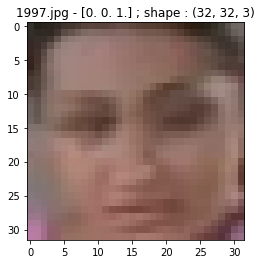

In [82]:
## Displaying random images without resizing them

#i = np.random.choice(np.arange(len(train_data)))

plt.title('{} - {} ; shape : {}'.format(train['ID'].values[i], y_train[i], train_data[i].shape))
plt.imshow(train_data[i])

In [98]:
#normalizing the data to avoid overfitting and outliers
X_train = np.array(train_data, np.float32) / 255.
X_test = np.array(test_data, np.float32) / 255.

In [99]:
# Encoding image labels into target variables (categorical) for easier classification
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)

ohe = OneHotEncoder(categorical_features = [0])
y_train = ohe.fit_transform(y_train.reshape(-1,1)).toarray()

C:\Users\shwee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\shwee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:451: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


In [100]:
#shape of training data
y_train.shape

(19906, 3)

In [102]:

# Importing the Keras libraries and packages for building models
import keras
from keras.models import Sequential, Model
from keras.layers import *
from keras.layers.advanced_activations import PReLU, LeakyReLU, ELU
from keras.optimizers import SGD
from keras.constraints import maxnorm

from keras import backend as K

from keras.preprocessing import image

In [104]:
#using theano as the backend
os.environ['KERAS_BACKEND'] = 'theano'
K

<module 'keras.backend' from 'C:\\Users\\shwee\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\keras\\backend\\__init__.py'>

* CNN with BatchNorm + with DropouT*

In [105]:
model = Sequential([
        BatchNormalization(input_shape = (32,32,3)),
        Convolution2D(32,(3,3), activation='relu'),
        BatchNormalization(),
        Convolution2D(32,(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Convolution2D(64,(3,3), activation='relu'),
        BatchNormalization(),
        Convolution2D(64,(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Flatten(),
        Dropout(0.3),
        Dense(384, activation='relu'),
        Dropout(0.6),
        Dense(3, activation='softmax')
        ])
model.compile(optimizer = 'adam' , loss='categorical_crossentropy', metrics=['accuracy'])

W1007 11:15:09.957281 12556 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


In [106]:
model.save_weights('initial_weights.h5')

In [107]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_44 (Batc (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_45 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_46 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 12, 12, 64)       

Model 2 : Same as Model 1, but with image size resized to 128 and hence, more Conv-Pool layers

In [108]:
model = Sequential([
        BatchNormalization(input_shape = (128,128,3)),
        Convolution2D(32,(3,3), activation='relu'),
        BatchNormalization(),
        Convolution2D(32,(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Convolution2D(64,(3,3), activation='relu'),
        BatchNormalization(),
        Convolution2D(64,(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Convolution2D(64,(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Convolution2D(64,(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Flatten(),
        Dropout(0.3),
        Dense(512, activation='relu'),
        Dropout(0.6),
        Dense(3, activation='softmax')
        ])
model.compile(optimizer = 'adam' , loss='categorical_crossentropy', metrics=['accuracy'])

W1007 11:18:14.353031 12556 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


In [109]:
model.save_weights('initial_weights.h5')

Model 3: Stacked CNN with BatchNormalisation and Advanced Activation Layers

In [110]:
model = Sequential([
        BatchNormalization(input_shape = (32,32,3)),
        Convolution2D(32,(3,3), activation='linear'),
        LeakyReLU(alpha = 0.3),
        BatchNormalization(),
        Convolution2D(32,(3,3), activation='linear'),
        LeakyReLU(alpha = 0.3),
        BatchNormalization(),
        MaxPooling2D(),
        Convolution2D(64,(3,3), activation='linear'),
        LeakyReLU(alpha = 0.3),
        BatchNormalization(),
        Convolution2D(64,(3,3), activation='linear'),
        LeakyReLU(alpha = 0.3),
        BatchNormalization(),
        MaxPooling2D(),
        Flatten(),
        Dropout(0.3),
        Dense(384, activation='linear'),
        LeakyReLU(alpha = 0.3),
        Dropout(0.6),
        Dense(3, activation='softmax')
        ])
model.compile(optimizer = 'adam' , loss='categorical_crossentropy', metrics=['accuracy'])

W1007 11:20:29.544262 12556 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


In [111]:
model.save_weights('initial_weights.h5')

In [112]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_56 (Batc (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization_57 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_58 (Batc (None, 28, 28, 32)      

MODEL TRAINING

In [113]:

## Building a custom function for learning rate decay/annealing
def lr_decay(start, stop, div_step_1, div_step_2 = 2) :
    k = 1
    while start >= stop:
        yield start
        if k==1 :
            start/= div_step_1
        else : start/= div_step_2
        k = k * -1

TRAINING WITHOUT DATA AUGMENTATION

In [114]:

# Training the model
model.fit(X_train, y_train, batch_size=32, epochs=2, validation_split=0.2)

Train on 15924 samples, validate on 3982 samples
Epoch 1/2


 5888/15924 [==========>...................] - ETA: 45:48 - loss: 2.9989 - accuracy: 0.250 - ETA: 24:28 - loss: 3.8241 - accuracy: 0.328 - ETA: 17:24 - loss: 3.5261 - accuracy: 0.385 - ETA: 13:50 - loss: 3.3293 - accuracy: 0.398 - ETA: 11:42 - loss: 3.5228 - accuracy: 0.368 - ETA: 10:17 - loss: 3.5031 - accuracy: 0.375 - ETA: 9:14 - loss: 3.5052 - accuracy: 0.370 - ETA: 8:29 - loss: 3.3525 - accuracy: 0.37 - ETA: 7:53 - loss: 3.2351 - accuracy: 0.38 - ETA: 7:24 - loss: 3.1357 - accuracy: 0.39 - ETA: 7:00 - loss: 3.1545 - accuracy: 0.39 - ETA: 6:40 - loss: 3.0626 - accuracy: 0.40 - ETA: 6:24 - loss: 3.0684 - accuracy: 0.41 - ETA: 6:10 - loss: 3.0430 - accuracy: 0.41 - ETA: 5:57 - loss: 3.0226 - accuracy: 0.42 - ETA: 5:46 - loss: 3.0002 - accuracy: 0.42 - ETA: 5:35 - loss: 2.9750 - accuracy: 0.43 - ETA: 5:26 - loss: 2.9672 - accuracy: 0.43 - ETA: 5:19 - loss: 2.9065 - accuracy: 0.44 - ETA: 5:11 - loss: 2.8389 - accuracy: 0.45 - ETA: 5:05 - loss: 2.8075 - accuracy: 0.45 - ETA: 4:59 - loss

15924/15924 [==============================] - ETA: 50s - loss: 1.4080 - accuracy: 0.561 - ETA: 49s - loss: 1.4060 - accuracy: 0.562 - ETA: 49s - loss: 1.4044 - accuracy: 0.562 - ETA: 48s - loss: 1.4030 - accuracy: 0.562 - ETA: 48s - loss: 1.4013 - accuracy: 0.562 - ETA: 48s - loss: 1.4016 - accuracy: 0.562 - ETA: 47s - loss: 1.3996 - accuracy: 0.562 - ETA: 47s - loss: 1.3998 - accuracy: 0.562 - ETA: 46s - loss: 1.3978 - accuracy: 0.563 - ETA: 46s - loss: 1.3963 - accuracy: 0.563 - ETA: 46s - loss: 1.3955 - accuracy: 0.563 - ETA: 45s - loss: 1.3940 - accuracy: 0.563 - ETA: 45s - loss: 1.3926 - accuracy: 0.563 - ETA: 44s - loss: 1.3911 - accuracy: 0.563 - ETA: 44s - loss: 1.3901 - accuracy: 0.564 - ETA: 44s - loss: 1.3889 - accuracy: 0.564 - ETA: 43s - loss: 1.3877 - accuracy: 0.564 - ETA: 43s - loss: 1.3870 - accuracy: 0.564 - ETA: 42s - loss: 1.3856 - accuracy: 0.564 - ETA: 42s - loss: 1.3848 - accuracy: 0.564 - ETA: 42s - loss: 1.3829 - accuracy: 0.565 - ETA: 41s - loss: 1.3817 - acc

 5952/15924 [==========>...................] - ETA: 3:17 - loss: 1.0896 - accuracy: 0.59 - ETA: 3:15 - loss: 1.0319 - accuracy: 0.57 - ETA: 3:18 - loss: 0.9218 - accuracy: 0.61 - ETA: 3:17 - loss: 0.9080 - accuracy: 0.60 - ETA: 3:20 - loss: 0.9004 - accuracy: 0.61 - ETA: 3:18 - loss: 0.8726 - accuracy: 0.63 - ETA: 3:16 - loss: 0.8751 - accuracy: 0.62 - ETA: 3:16 - loss: 0.8688 - accuracy: 0.64 - ETA: 3:13 - loss: 0.8391 - accuracy: 0.64 - ETA: 3:11 - loss: 0.8516 - accuracy: 0.63 - ETA: 3:10 - loss: 0.8531 - accuracy: 0.63 - ETA: 3:09 - loss: 0.8439 - accuracy: 0.64 - ETA: 3:08 - loss: 0.8499 - accuracy: 0.64 - ETA: 3:07 - loss: 0.8240 - accuracy: 0.65 - ETA: 3:07 - loss: 0.8245 - accuracy: 0.65 - ETA: 3:07 - loss: 0.8455 - accuracy: 0.65 - ETA: 3:06 - loss: 0.8466 - accuracy: 0.64 - ETA: 3:06 - loss: 0.8468 - accuracy: 0.64 - ETA: 3:06 - loss: 0.8380 - accuracy: 0.64 - ETA: 3:05 - loss: 0.8413 - accuracy: 0.64 - ETA: 3:05 - loss: 0.8411 - accuracy: 0.64 - ETA: 3:04 - loss: 0.8380 - ac

15924/15924 [==============================] - ETA: 48s - loss: 0.7800 - accuracy: 0.660 - ETA: 48s - loss: 0.7803 - accuracy: 0.660 - ETA: 47s - loss: 0.7803 - accuracy: 0.660 - ETA: 47s - loss: 0.7802 - accuracy: 0.660 - ETA: 47s - loss: 0.7796 - accuracy: 0.660 - ETA: 46s - loss: 0.7799 - accuracy: 0.660 - ETA: 46s - loss: 0.7801 - accuracy: 0.659 - ETA: 45s - loss: 0.7797 - accuracy: 0.660 - ETA: 45s - loss: 0.7793 - accuracy: 0.660 - ETA: 45s - loss: 0.7794 - accuracy: 0.660 - ETA: 44s - loss: 0.7789 - accuracy: 0.660 - ETA: 44s - loss: 0.7795 - accuracy: 0.659 - ETA: 44s - loss: 0.7794 - accuracy: 0.659 - ETA: 43s - loss: 0.7791 - accuracy: 0.660 - ETA: 43s - loss: 0.7791 - accuracy: 0.660 - ETA: 42s - loss: 0.7790 - accuracy: 0.660 - ETA: 42s - loss: 0.7798 - accuracy: 0.659 - ETA: 42s - loss: 0.7796 - accuracy: 0.659 - ETA: 41s - loss: 0.7798 - accuracy: 0.659 - ETA: 41s - loss: 0.7794 - accuracy: 0.659 - ETA: 40s - loss: 0.7786 - accuracy: 0.660 - ETA: 40s - loss: 0.7791 - acc

In [123]:
#model.optimizer.lr=0.0001
model.save_weights('age-detection_weights.h5')

WITH DATA AUGMENTATION

In [125]:
#train-test split for training model
from sklearn.model_selection import train_test_split
X_trn, X_valid, y_trn, y_valid = train_test_split(X_train, y_train, test_size = 0.2)

In [126]:
#image data generator
gen = image.ImageDataGenerator(rotation_range=15, width_shift_range=0.1, shear_range=0.25,
                               height_shift_range=0.1, zoom_range=0.2, horizontal_flip = True)
batches = gen.flow(X_trn, y_trn, batch_size = 64)
val_batches = gen.flow(X_valid, y_valid, batch_size = 128)

In [127]:
#model.optimizer.lr = 0.001

AttributeError: can't set attribute

In [128]:
#run model
model.fit_generator(batches, (X_trn.shape[0]//batches.batch_size), epochs=1,
                    validation_data = val_batches, validation_steps = (X_valid.shape[0]//val_batches.batch_size))

Epoch 1/1


186/248 [=====================>........] - ETA: 5:37 - loss: 0.8527 - accuracy: 0.59 - ETA: 5:03 - loss: 0.8418 - accuracy: 0.60 - ETA: 4:39 - loss: 0.7965 - accuracy: 0.61 - ETA: 4:23 - loss: 0.7587 - accuracy: 0.64 - ETA: 4:10 - loss: 0.7753 - accuracy: 0.64 - ETA: 4:00 - loss: 0.8100 - accuracy: 0.64 - ETA: 3:53 - loss: 0.8131 - accuracy: 0.63 - ETA: 3:48 - loss: 0.8211 - accuracy: 0.64 - ETA: 3:44 - loss: 0.8116 - accuracy: 0.64 - ETA: 3:40 - loss: 0.7977 - accuracy: 0.65 - ETA: 3:37 - loss: 0.8002 - accuracy: 0.65 - ETA: 3:34 - loss: 0.7934 - accuracy: 0.65 - ETA: 3:31 - loss: 0.7872 - accuracy: 0.65 - ETA: 3:28 - loss: 0.7828 - accuracy: 0.66 - ETA: 3:26 - loss: 0.7842 - accuracy: 0.66 - ETA: 3:24 - loss: 0.7827 - accuracy: 0.66 - ETA: 3:22 - loss: 0.7813 - accuracy: 0.66 - ETA: 3:20 - loss: 0.7796 - accuracy: 0.66 - ETA: 3:19 - loss: 0.7780 - accuracy: 0.66 - ETA: 3:17 - loss: 0.7805 - accuracy: 0.66 - ETA: 3:16 - loss: 0.7788 - accuracy: 0.66 - ETA: 3:15 - loss: 0.7768 - accura

In [131]:
model.save_weights('aug_age-detection_weights.h5')

AUTO ENCODERS

In [132]:
## Building the autoencoder

input_img = Input(shape=(32, 32, 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (8, 4, 4, 3) i.e. 384-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding = 'same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [133]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

W1007 11:49:38.139378 12556 deprecation.py:323] From C:\Users\shwee\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [134]:
#summary
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 16, 16, 16)        4624      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 8, 8, 8)           1160      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 4, 4, 8)           0   

In [135]:
!tensorboard --logdir = /tmp/autoencoder

usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--host ADDR]
                   [--port PORT] [--purge_orphaned_data BOOL]
                   [--reload_interval SECONDS] [--db URI] [--db_import]
                   [--db_import_use_op] [--inspect] [--version_tb] [--tag TAG]
                   [--event_file PATH] [--path_prefix PATH]
                   [--window_title TEXT] [--max_reload_threads COUNT]
                   [--reload_task TYPE]
                   [--samples_per_plugin SAMPLES_PER_PLUGIN]
                   [--debugger_data_server_grpc_port PORT]
                   [--debugger_port PORT] [--master_tpu_unsecure_channel ADDR]
tensorboard: error: unrecognized arguments: /tmp/autoencoder


In [136]:
from keras.callbacks import TensorBoard

In [137]:
#auto encoder with 64 as batch size
autoencoder.fit(X_train, X_train,
                epochs= 10,
                batch_size= 64,
                shuffle= True,
                validation_data= (X_test, X_test))
                #callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 19906 samples, validate on 6636 samples
Epoch 1/10
19906/19906 [==============================] - ETA: 5:44 - loss: 0.693 - ETA: 3:24 - loss: 0.692 - ETA: 2:37 - loss: 0.692 - ETA: 2:15 - loss: 0.692 - ETA: 2:01 - loss: 0.691 - ETA: 1:51 - loss: 0.690 - ETA: 1:44 - loss: 0.690 - ETA: 1:39 - loss: 0.689 - ETA: 1:35 - loss: 0.688 - ETA: 1:32 - loss: 0.687 - ETA: 1:29 - loss: 0.686 - ETA: 1:27 - loss: 0.684 - ETA: 1:25 - loss: 0.683 - ETA: 1:24 - loss: 0.681 - ETA: 1:22 - loss: 0.679 - ETA: 1:21 - loss: 0.678 - ETA: 1:20 - loss: 0.677 - ETA: 1:19 - loss: 0.676 - ETA: 1:20 - loss: 0.675 - ETA: 1:19 - loss: 0.674 - ETA: 1:18 - loss: 0.673 - ETA: 1:17 - loss: 0.673 - ETA: 1:16 - loss: 0.672 - ETA: 1:15 - loss: 0.670 - ETA: 1:14 - loss: 0.670 - ETA: 1:14 - loss: 0.669 - ETA: 1:13 - loss: 0.668 - ETA: 1:12 - loss: 0.668 - ETA: 1:12 - loss: 0.667 - ETA: 1:12 - loss: 0.666 - ETA: 1:12 - loss: 0.666 - ETA: 1:12 - loss: 0.665 - ETA: 1:11 - loss: 0.665 - ETA: 1:11 - loss: 0.665 - ETA: 1:10

19906/19906 [==============================] - ETA: 1:18 - loss: 0.602 - ETA: 1:17 - loss: 0.601 - ETA: 1:17 - loss: 0.599 - ETA: 1:17 - loss: 0.597 - ETA: 1:18 - loss: 0.594 - ETA: 1:17 - loss: 0.592 - ETA: 1:18 - loss: 0.591 - ETA: 1:17 - loss: 0.592 - ETA: 1:17 - loss: 0.592 - ETA: 1:17 - loss: 0.592 - ETA: 1:17 - loss: 0.592 - ETA: 1:16 - loss: 0.593 - ETA: 1:15 - loss: 0.593 - ETA: 1:14 - loss: 0.594 - ETA: 1:13 - loss: 0.594 - ETA: 1:12 - loss: 0.595 - ETA: 1:11 - loss: 0.595 - ETA: 1:10 - loss: 0.595 - ETA: 1:10 - loss: 0.594 - ETA: 1:09 - loss: 0.595 - ETA: 1:09 - loss: 0.595 - ETA: 1:08 - loss: 0.595 - ETA: 1:07 - loss: 0.595 - ETA: 1:07 - loss: 0.595 - ETA: 1:07 - loss: 0.595 - ETA: 1:06 - loss: 0.595 - ETA: 1:06 - loss: 0.595 - ETA: 1:05 - loss: 0.596 - ETA: 1:05 - loss: 0.595 - ETA: 1:04 - loss: 0.596 - ETA: 1:04 - loss: 0.596 - ETA: 1:04 - loss: 0.596 - ETA: 1:03 - loss: 0.595 - ETA: 1:03 - loss: 0.595 - ETA: 1:02 - loss: 0.595 - ETA: 1:02 - loss: 0.595 - ETA: 1:02 - loss:

19906/19906 [==============================] - ETA: 1:11 - loss: 0.587 - ETA: 1:14 - loss: 0.589 - ETA: 1:13 - loss: 0.592 - ETA: 1:14 - loss: 0.590 - ETA: 1:14 - loss: 0.592 - ETA: 1:13 - loss: 0.591 - ETA: 1:13 - loss: 0.590 - ETA: 1:13 - loss: 0.589 - ETA: 1:13 - loss: 0.588 - ETA: 1:13 - loss: 0.588 - ETA: 1:12 - loss: 0.589 - ETA: 1:12 - loss: 0.588 - ETA: 1:11 - loss: 0.588 - ETA: 1:10 - loss: 0.588 - ETA: 1:09 - loss: 0.588 - ETA: 1:08 - loss: 0.589 - ETA: 1:07 - loss: 0.588 - ETA: 1:07 - loss: 0.589 - ETA: 1:06 - loss: 0.588 - ETA: 1:05 - loss: 0.588 - ETA: 1:05 - loss: 0.588 - ETA: 1:04 - loss: 0.588 - ETA: 1:04 - loss: 0.588 - ETA: 1:03 - loss: 0.588 - ETA: 1:03 - loss: 0.587 - ETA: 1:03 - loss: 0.588 - ETA: 1:02 - loss: 0.588 - ETA: 1:02 - loss: 0.587 - ETA: 1:01 - loss: 0.587 - ETA: 1:01 - loss: 0.587 - ETA: 1:01 - loss: 0.587 - ETA: 1:00 - loss: 0.587 - ETA: 1:00 - loss: 0.587 - ETA: 1:00 - loss: 0.588 - ETA: 59s - loss: 0.588 - ETA: 59s - loss: 0.58 - ETA: 59s - loss: 0.5

19906/19906 [==============================] - ETA: 1:23 - loss: 0.583 - ETA: 1:23 - loss: 0.578 - ETA: 1:23 - loss: 0.579 - ETA: 1:23 - loss: 0.579 - ETA: 1:22 - loss: 0.578 - ETA: 1:23 - loss: 0.578 - ETA: 1:23 - loss: 0.578 - ETA: 1:22 - loss: 0.579 - ETA: 1:22 - loss: 0.578 - ETA: 1:22 - loss: 0.580 - ETA: 1:22 - loss: 0.580 - ETA: 1:22 - loss: 0.582 - ETA: 1:21 - loss: 0.582 - ETA: 1:21 - loss: 0.582 - ETA: 1:21 - loss: 0.581 - ETA: 1:21 - loss: 0.582 - ETA: 1:20 - loss: 0.583 - ETA: 1:20 - loss: 0.584 - ETA: 1:20 - loss: 0.584 - ETA: 1:20 - loss: 0.584 - ETA: 1:19 - loss: 0.584 - ETA: 1:19 - loss: 0.584 - ETA: 1:19 - loss: 0.584 - ETA: 1:18 - loss: 0.584 - ETA: 1:18 - loss: 0.584 - ETA: 1:18 - loss: 0.584 - ETA: 1:18 - loss: 0.584 - ETA: 1:17 - loss: 0.583 - ETA: 1:17 - loss: 0.583 - ETA: 1:17 - loss: 0.583 - ETA: 1:17 - loss: 0.584 - ETA: 1:17 - loss: 0.584 - ETA: 1:16 - loss: 0.584 - ETA: 1:16 - loss: 0.584 - ETA: 1:16 - loss: 0.584 - ETA: 1:15 - loss: 0.584 - ETA: 1:15 - loss:

19906/19906 [==============================] - ETA: 1:27 - loss: 0.581 - ETA: 1:33 - loss: 0.581 - ETA: 1:30 - loss: 0.583 - ETA: 1:35 - loss: 0.580 - ETA: 1:31 - loss: 0.582 - ETA: 1:29 - loss: 0.582 - ETA: 1:29 - loss: 0.582 - ETA: 1:27 - loss: 0.582 - ETA: 1:26 - loss: 0.581 - ETA: 1:25 - loss: 0.582 - ETA: 1:24 - loss: 0.584 - ETA: 1:23 - loss: 0.584 - ETA: 1:22 - loss: 0.584 - ETA: 1:22 - loss: 0.583 - ETA: 1:21 - loss: 0.583 - ETA: 1:20 - loss: 0.583 - ETA: 1:20 - loss: 0.583 - ETA: 1:20 - loss: 0.582 - ETA: 1:19 - loss: 0.582 - ETA: 1:19 - loss: 0.582 - ETA: 1:18 - loss: 0.582 - ETA: 1:18 - loss: 0.582 - ETA: 1:17 - loss: 0.582 - ETA: 1:17 - loss: 0.582 - ETA: 1:16 - loss: 0.581 - ETA: 1:16 - loss: 0.581 - ETA: 1:16 - loss: 0.582 - ETA: 1:15 - loss: 0.581 - ETA: 1:15 - loss: 0.582 - ETA: 1:15 - loss: 0.582 - ETA: 1:14 - loss: 0.583 - ETA: 1:14 - loss: 0.583 - ETA: 1:13 - loss: 0.583 - ETA: 1:13 - loss: 0.583 - ETA: 1:13 - loss: 0.583 - ETA: 1:12 - loss: 0.583 - ETA: 1:12 - loss:

In [138]:
#auto encoder with batch size 128
autoencoder.fit(X_train, X_train,
                epochs= 3,
                batch_size= 128,
                shuffle= True,
                validation_data= (X_test, X_test))

Train on 19906 samples, validate on 6636 samples
Epoch 1/3
19906/19906 [==============================] - ETA: 1:11 - loss: 0.588 - ETA: 1:09 - loss: 0.589 - ETA: 1:08 - loss: 0.588 - ETA: 1:07 - loss: 0.588 - ETA: 1:09 - loss: 0.585 - ETA: 1:07 - loss: 0.586 - ETA: 1:06 - loss: 0.585 - ETA: 1:04 - loss: 0.585 - ETA: 1:04 - loss: 0.582 - ETA: 1:02 - loss: 0.583 - ETA: 1:02 - loss: 0.583 - ETA: 1:01 - loss: 0.583 - ETA: 1:00 - loss: 0.582 - ETA: 59s - loss: 0.582 - ETA: 59s - loss: 0.58 - ETA: 58s - loss: 0.58 - ETA: 58s - loss: 0.58 - ETA: 57s - loss: 0.58 - ETA: 57s - loss: 0.58 - ETA: 56s - loss: 0.58 - ETA: 56s - loss: 0.58 - ETA: 55s - loss: 0.58 - ETA: 55s - loss: 0.58 - ETA: 54s - loss: 0.58 - ETA: 54s - loss: 0.58 - ETA: 53s - loss: 0.58 - ETA: 53s - loss: 0.58 - ETA: 52s - loss: 0.58 - ETA: 52s - loss: 0.58 - ETA: 51s - loss: 0.58 - ETA: 51s - loss: 0.58 - ETA: 50s - loss: 0.58 - ETA: 50s - loss: 0.58 - ETA: 50s - loss: 0.58 - ETA: 49s - loss: 0.58 - ETA: 49s - loss: 0.58 - ETA

In [139]:
#new shape
X_test.shape

(6636, 32, 32, 3)

In [140]:
#prediction
decoded_imgs = autoencoder.predict(X_test)

In [141]:
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis= 1)

In [142]:
# Converting predicted category numbers to predicted labels
unique_labels = np.unique(train['Class'].tolist())
pred_labels = unique_labels[predictions]

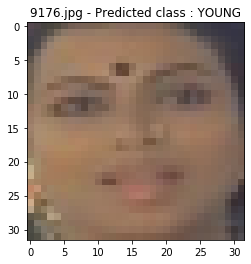

In [146]:
#testing model
i = np.random.choice(np.arange(len(test_data)))
plt.title('{} - Predicted class : {}'.format(test['ID'].values[i], pred_labels[i]))
plt.imshow(test_data[i])

In [147]:
#save model
subm = pd.DataFrame({'Class':pred_labels, 'ID':test.ID})
subm.to_csv('predictions.csv', index=False)